# Main script for SOH estimation

# CHEM ENG 277 
# Jessica Luu, Cody Koffman, Karime Hernandez Perez 
# 
# This script performs a multivariate regression on the Oxford Battery Degradation Dataset collected 
# by Cristoph Birkl at Oxford University.

In [2]:
#Import needed packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 
from scipy.stats import kurtosis
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score  #Performance metrics
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, LeaveOneGroupOut, KFold, GridSearchCV, cross_val_score  #Cross validation
import seaborn as sns  
import gc  

Processing chunk 1 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv...
Processing chunk 2 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv...
Processing chunk 3 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv...
Processing chunk 4 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv...
Processing chunk 5 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv...
Processing chunk 6 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv...
Processing chunk 7 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv...
Processing chunk 1 from C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_OCVdc.csv...
Processing chunk 2 from C:\Users\Work\OneDrive - Stanford\Documents\Py scrip

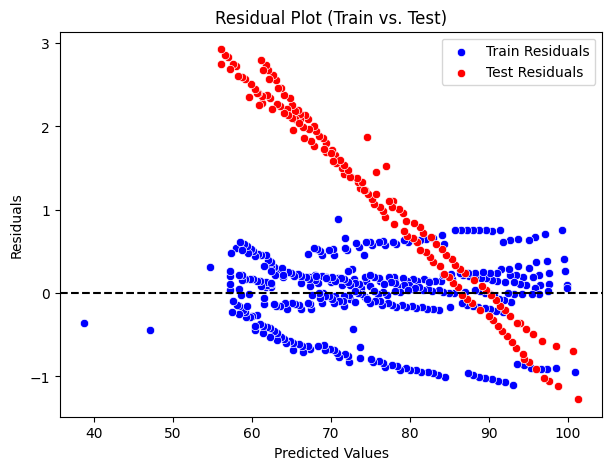

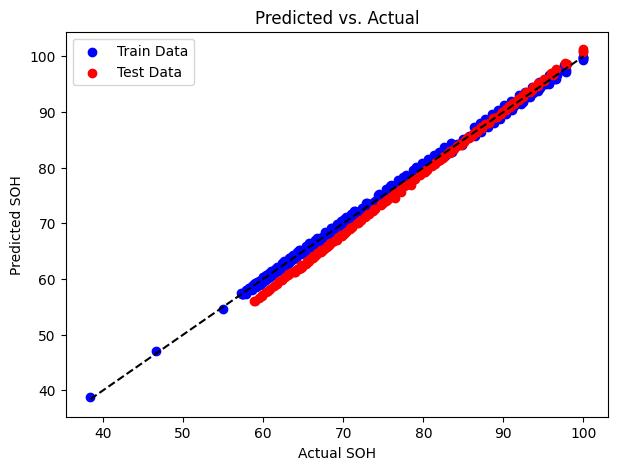

In [ ]:
#Load and Preprocess Data (Discharge and OCV data)
discharge_file = r'C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_discharge.csv'
ocv_charge_file = r'C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_OCVch.csv'
ocv_discharge_file = r'C:\Users\Work\OneDrive - Stanford\Documents\Py scripts\Oxford_battery_data_OCVdc.csv'


#Function to process data in chunks
def load_and_process_in_chunks(filename, usecols, chunk_size=250000):
    chunks = pd.read_csv(filename, chunksize=chunk_size, usecols=usecols, low_memory=False)
    result = pd.DataFrame()
    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i+1} from {filename}...")
        result = pd.concat([result, chunk])
    return result



discharge_data = load_and_process_in_chunks(
    discharge_file,
    usecols=['cell_number', 'cycle_number', 'time', 'voltage', 'current', 'temperature']
)

# Sort discharge data
discharge_data = discharge_data.sort_values(by=['cell_number', 'cycle_number', 'time'])

# Set time_diff to 1 second as per requirement
discharge_data['time_diff'] = 1

# Compute discharge capacity incrementally
discharge_data['incremental_discharge'] = (discharge_data['current'] * discharge_data['time_diff']).abs() / 3600
discharge_data['discharge_capacity'] = discharge_data.groupby(['cell_number', 'cycle_number'])['incremental_discharge'].cumsum() * 1000


#Dictionary of how to aggregate the data for each cycle_number per each cell_number
agg_funcs = {
    'voltage': 'mean',
    'discharge_capacity': 'max',
    'temperature': 'mean',
    'current': ['mean', 'var', lambda x: kurtosis(x, fisher=True)]}  # Variance & kurtosis

#Compute grouped statistics
grouped = discharge_data.groupby(['cell_number', 'cycle_number']).agg(agg_funcs).reset_index()

#Rename columns for clarity
grouped.columns = ['cell_number', 'cycle_number', 'avg_voltage', 'max_discharge_capacity', 
                   'avg_temperature', 'avg_current', 'current_variance', 'current_kurtosis']

valid_cycles = grouped[['cell_number', 'cycle_number']].drop_duplicates()

# Free up memory
del discharge_data
gc.collect()

ocv_discharge = load_and_process_in_chunks(
    ocv_discharge_file,
    usecols=['cell_number', 'cycle_number', 'voltage'],
    chunk_size=500000
)

ocv_charge = load_and_process_in_chunks(
    ocv_charge_file,
    usecols=['cell_number', 'cycle_number', 'voltage'],
    chunk_size=500000
)

# Filter OCV data using left join to avoid excessive row loss
ocv_discharge = pd.merge(
    ocv_discharge,
    valid_cycles,
    on=['cell_number', 'cycle_number'],
    how='left'
).dropna()

ocv_charge = pd.merge(
    ocv_charge,
    valid_cycles,
    on=['cell_number', 'cycle_number'],
    how='left'
).dropna()

# Aggregate OCV data
ocv_discharge_agg = ocv_discharge.groupby(['cell_number', 'cycle_number']).agg({'voltage': 'mean'}).reset_index()
ocv_charge_agg = ocv_charge.groupby(['cell_number', 'cycle_number']).agg({'voltage': 'mean'}).reset_index()

# Merge to compute hysteresis
ocv_hysteresis_df = pd.merge(
    ocv_charge_agg,
    ocv_discharge_agg,
    on=['cell_number', 'cycle_number'],
    suffixes=('_ch', '_dis')
)

# Compute hysteresis feature
ocv_hysteresis_df['OCV_hysteresis'] = ocv_hysteresis_df['voltage_ch'] - ocv_hysteresis_df['voltage_dis']
ocv_hysteresis_df.drop(columns=['voltage_ch', 'voltage_dis'], inplace=True)

# Fill missing values using per-cell median
ocv_hysteresis_df['OCV_hysteresis'] = ocv_hysteresis_df.groupby('cell_number')['OCV_hysteresis'].transform(
    lambda x: x.fillna(x.median() if not pd.isna(x.median()) else 0)
)

# Free up memory
del ocv_charge
del ocv_discharge
del ocv_charge_agg
del ocv_discharge_agg
gc.collect()


#Training/testing 


def evaluate_metrics(y_, y_pred):
    '''Evaluates metrics of interest on test or training set'''
    mse = mean_squared_error(y_, y_pred) # Mean Squared Error
    rmse = root_mean_squared_error(y_, y_pred)  # Root Mean Squared Error
    mae = mean_absolute_error(y_, y_pred) # Mean Absolute Error
    r2 = r2_score(y_, y_pred)  # R-squared
    return mse, rmse, mae, r2

def print_metrics(y_, y_pred, type):
    mse, rmse, mae, r2 = evaluate_metrics(y_, y_pred)
    metrics_df = pd.DataFrame(
        {"MSE": [mse], "RMSE": [rmse], "MAE": [mae], "R²": [r2]}
    )

    # Print the table
    print("Metrics for" + str(type) + " set:\n")
    print(metrics_df.to_string(index=False))


grouped = pd.merge(grouped, ocv_hysteresis_df, on=['cell_number', 'cycle_number'])


# Compute State of Health (SOH)
grouped['SOH'] = (
    grouped['max_discharge_capacity'] / grouped.groupby('cell_number')['max_discharge_capacity'].transform('first')
) * 100

features = ['cycle_number','avg_temperature','avg_current','current_kurtosis','current_variance','OCV_hysteresis'] 

X = grouped[features].values
y = grouped['SOH'].values

# Split into first 6 battery cells (cell_number 1-6)
train = grouped[grouped["cell_number"].between(1, 6)]

# Split into last 2 battery cells (cell_number 7-8)
test = grouped[grouped["cell_number"].between(7, 8)]

#Initialize variables for train/test sets 
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features].values)
X_test = scaler.fit_transform(test[features].values)
y_train = train['SOH'].values
y_test = test['SOH'].values


y_train = np.nan_to_num(y_train, nan=np.nanmedian(y_train))
y_test = np.nan_to_num(y_test, nan=np.nanmedian(y_test))

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate metrics for the training and test set
print_metrics(y_test, y_pred_test, 'test')
print_metrics(y_train, y_pred_train, 'train')

train_residuals = y_train - model.predict(X_train)
test_residuals = y_test - model.predict(X_test)


print("OLS Model Parameters:\n") 
print("   Features:", features)
print("   Coefficients:", model.coef_)
print("   Intercept:", model.intercept_)


#Plot of residuals 
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred_train, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_pred_test, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Train vs. Test)")

#Parity plot 
plt.figure(figsize=(7,5))
plt.scatter(y_train, y_pred_train, color="blue", label="Train Data")
plt.scatter(y_test, y_pred_test, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs. Actual")
plt.legend()
plt.show()


Metrics fortest set:

     MSE     RMSE      MAE       R²
2.640815 1.625058 1.379505 0.978364
Metrics fortrain set:

     MSE     RMSE     MAE     R²
0.189118 0.434877 0.33042 0.9987
OLS Model Parameters:

   Features: ['cycle_number', 'avg_temperature', 'avg_current', 'current_kurtosis', 'current_variance', 'OCV_hysteresis']
   Coefficients: [-9.05861971e-01  8.47153860e-02  4.14723822e+00  5.49269808e-03
  1.51402877e+01 -2.85939079e-01]
   Intercept: 75.57841354061713


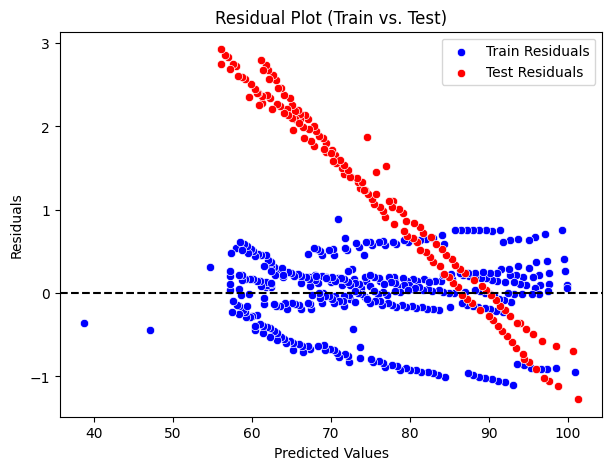

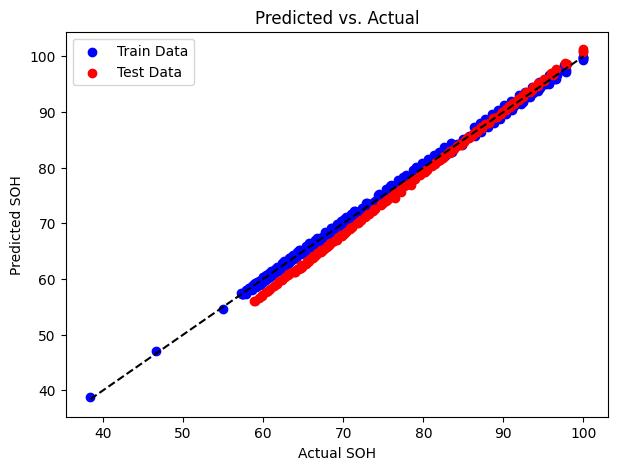


GroupKFold Cross Validation using Linear Regression (k=4):
Fold 1:
  Train Battery IDs: [2 3 4 5 7 8]
  Test Battery IDs: [1 6]
  Fold R^2 (Train): 0.9966, Fold R^2 (Test): 0.9872
  RMSE: 1.3361, MSE: 1.7851, MAE: 0.9886
  Coefficients: [ 3.67318689e-02  2.39424538e-01 -1.11012140e-01  1.30035027e+03
  1.87326785e-03  3.23996954e+01], Intercept: 1525.341865163368

Fold 2:
  Train Battery IDs: [1 2 3 4 6 8]
  Test Battery IDs: [5 7]
  Fold R^2 (Train): 0.9957, Fold R^2 (Test): 0.9900
  RMSE: 1.0497, MSE: 1.1018, MAE: 0.9770
  Coefficients: [-1.54470782e-02  5.27861121e-02  3.77849604e-02  5.78039750e+03
  2.35492587e-03  1.23500270e+00], Intercept: 6942.451557643402

Fold 3:
  Train Battery IDs: [1 4 5 6 7 8]
  Test Battery IDs: [2 3]
  Fold R^2 (Train): 0.9937, Fold R^2 (Test): 0.9981
  RMSE: 0.5486, MSE: 0.3010, MAE: 0.4854
  Coefficients: [ 3.96462798e-02  5.70266592e-02 -2.42765813e-01  3.88060456e+03
  1.30135599e-03  6.71745340e+01], Intercept: 4605.443267728515

Fold 4:
  Train 

In [ ]:
# Training/testing 

def train_and_evaluate(train_idx, test_idx, fold):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
    model = linear_model.LinearRegression()
    model.fit(X_train_fold, y_train_fold)
    
    y_train_pred, y_test_pred = model.predict(X_train_fold), model.predict(X_test_fold)
    
    metrics_train = evaluate_metrics(y_train_fold, y_train_pred)
    metrics_test = evaluate_metrics(y_test_fold, y_test_pred)
    
    train_r2.append(metrics_train[3])
    test_r2.append(metrics_test[3])
    rmse_fold.append(metrics_test[1])
    mse_fold.append(metrics_test[0])
    mae_fold.append(metrics_test[2])
    
    train_groups, test_groups = np.unique(grouped.loc[train_idx, 'cell_number']), np.unique(grouped.loc[test_idx, 'cell_number'])
    
    print(f"Fold {fold}:")
    print(f"  Train Battery IDs: {train_groups}")
    print(f"  Test Battery IDs: {test_groups}")
    print(f"  Fold R^2 (Train): {metrics_train[3]:.4f}, Fold R^2 (Test): {metrics_test[3]:.4f}")
    print(f"  RMSE: {metrics_test[1]:.4f}, MSE: {metrics_test[0]:.4f}, MAE: {metrics_test[2]:.4f}")
    print(f"  Coefficients: {model.coef_}, Intercept: {model.intercept_}\n")



grouped = pd.merge(grouped, ocv_hysteresis_df, on=['cell_number', 'cycle_number'])

# Compute State of Health (SOH)
grouped['SOH'] = (
    grouped['max_discharge_capacity'] / grouped.groupby('cell_number')['max_discharge_capacity'].transform('first')
) * 100

features = ['cycle_number','avg_temperature','avg_current','current_kurtosis','current_variance','OCV_hysteresis'] 

X = grouped[features].values
y = grouped['SOH'].values

# Split into first 6 battery cells (cell_number 1-6)
train = grouped[grouped["cell_number"].between(1, 6)]

# Split into last 2 battery cells (cell_number 7-8)
test = grouped[grouped["cell_number"].between(7, 8)]

# Initialize variables for train/test sets 
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features].values)
X_test = scaler.fit_transform(test[features].values)
y_train = train['SOH'].values
y_test = test['SOH'].values


y_train = np.nan_to_num(y_train, nan=np.nanmedian(y_train))
y_test = np.nan_to_num(y_test, nan=np.nanmedian(y_test))

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate metrics for the training and test set
print_metrics(y_test, y_pred_test, 'test')
print_metrics(y_train, y_pred_train, 'train')

train_residuals = y_train - model.predict(X_train)
test_residuals = y_test - model.predict(X_test)

print("OLS Model Parameters:\n") 
print("   Features:", features)
print("   Coefficients:", model.coef_)
print("   Intercept:", model.intercept_)

# Plot of residuals 
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred_train, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_pred_test, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Train vs. Test)")

# Parity plot 
plt.figure(figsize=(7,5))
plt.scatter(y_train, y_pred_train, color="blue", label="Train Data")
plt.scatter(y_test, y_pred_test, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs. Actual")
plt.legend()
plt.show()

# k-Fold Cross Validation using GroupKFold to estimate the performance of ordinary least-squares linear regression.
# We use k = 4. With 8 battery cells, a 4-fold split yields 2 cells per test fold (~25%).

gkf = GroupKFold(n_splits=4)  # Generate four different test/train splits 
fold = 1

groups = grouped['cell_number'].values  # There are 8 cells, so make 8 groups. This will keep the battery cells' data together. 
train_r2, test_r2, rmse_fold, mse_fold, mae_fold = [], [], [], [], []

print("\nGroupKFold Cross Validation using Linear Regression (k=4):")



for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups), 1):
    train_and_evaluate(train_idx, test_idx, fold)

print(f"\nAverage R^2 (Train): {np.mean(train_r2):.4f}")
print(f"Average R^2 (Test): {np.mean(test_r2):.4f}")
print(f"Average RMSE: {np.mean(rmse_fold):.4f}")
print(f"Average MSE: {np.mean(mse_fold):.4f}")
print(f"Average MAE: {np.mean(mae_fold):.4f}")



In [9]:
# k-Fold Cross Validation using GroupKFold to estimate the performance of ordinary least-squares linear regression.
# We use k = 4. With 8 battery cells, a 4-fold split yields 2 cells per test fold (~25%).

gkf = GroupKFold(n_splits=4) #Generate four different test/train splits 
fold = 1

groups = grouped['cell_number'].values #There are 8 cells, so make 8 groups. This will keep the battery cells' data together. 
train_r2, test_r2, rmse_fold, mse_fold, mae_fold = [], [], [], [], []

print("\nGroupKFold Cross Validation using Linear Regression (k=4):")

for train_idx, test_idx in gkf.split(X, y, groups): #Each fold considers different cells for test/train sets
    
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
    model = linear_model.LinearRegression() #Fit linear regression model on training data
    model.fit(X_train_fold, y_train_fold) 
    y_train_pred_fold = model.predict(X_train_fold) #Predicted y-values for training set
    y_pred_fold = model.predict(X_test_fold) #Predicted y-values for test set
    
    train_r2.append(r2_score(y_train_fold, y_train_pred_fold))
    test_r2.append(r2_score(y_test_fold, y_pred_fold))#R^2 for test data
    rmse_fold.append(root_mean_squared_error(y_test_fold, y_pred_fold)) #Root mean squared error (for test data)
    mse_fold.append(mean_squared_error(y_test_fold, y_pred_fold)) #Mean squared error (for test data)
    mae_fold.append(mean_absolute_error(y_test_fold, y_pred_fold)) #Mean absolute error (for test data)
    
    #Print out test/train groups and metrics 
    train_groups = np.unique(grouped.loc[train_idx, 'cell_number'])
    test_groups = np.unique(grouped.loc[test_idx, 'cell_number'])
    print(f"Fold {fold}:")
    print("  Train Battery IDs:", train_groups)
    print("  Test Battery IDs:", test_groups)
    print(f"  Fold R^2 on Training Set = {train_r2[fold-1]:.4f}")
    print(f"  Fold R^2 on Test Set = {test_r2[fold-1]:.4f}")
    print(f"  Fold RMSE: {rmse_fold[fold-1]:.4f}")
    print(f"  Fold MSE: {mse_fold[fold-1]:.4f}")
    print(f"  Fold MAE: {mae_fold[fold-1]:.4f}")
    print("  Coefficients", model.coef_)
    print("  Intercept:", model.intercept_)
    print("\n")
    fold += 1

#Compute and display the average metrics over all k=4 folds
avg_train_r2 = np.mean(train_r2)
avg_test_r2 = np.mean(test_r2)
avg_rmse_fold = np.mean(rmse_fold)
avg_mse_fold = np.mean(mse_fold)
avg_mae_fold = np.mean(mae_fold)

print("Average metrics over all folds for k=4:\n")
print(f"   R^2 Train: {avg_train_r2:.4f}")
print(f"   R^2 Test: {avg_test_r2:.4f}")
print(f"   RMSE: {avg_rmse_fold:.4f}")
print(f"   MSE: {avg_mse_fold:.4f}")
print(f"   MAE: {avg_mae_fold:.4f}\n")


GroupKFold Cross Validation using Linear Regression (k=4):
Fold 1:
  Train Battery IDs: [2 3 4 6 7 8]
  Test Battery IDs: [1 5]
  Fold R^2 on Training Set = 0.9975
  Fold R^2 on Test Set = 0.9487
  Fold RMSE: 2.7411
  Fold MSE: 7.5139
  Fold MAE: 1.5732
  Coefficients [ 2.66892837e-02  7.03502603e-01 -6.80176104e-02  3.45934557e+03
  2.02606187e-03 -2.32445252e+00]
  Intercept: 4107.178137926141


Fold 2:
  Train Battery IDs: [1 2 3 4 5 8]
  Test Battery IDs: [6 7]
  Fold R^2 on Training Set = 0.9957
  Fold R^2 on Test Set = 0.9882
  Fold RMSE: 1.0984
  Fold MSE: 1.2065
  Fold MAE: 1.0111
  Coefficients [-8.06877144e-03  3.10485183e-02  4.49455753e-02  5.45770101e+03
  2.40026176e-03 -1.01666637e+01]
  Intercept: 6556.815396926381


Fold 3:
  Train Battery IDs: [1 3 4 5 6 7]
  Test Battery IDs: [2 8]
  Fold R^2 on Training Set = 0.9959
  Fold R^2 on Test Set = 0.9924
  Fold RMSE: 1.0899
  Fold MSE: 1.1878
  Fold MAE: 0.8913
  Coefficients [ 3.62531103e-02  7.99270355e-02 -3.17511423e-

In [10]:
#Leave-One-Group-Out Cross Validation (LOOCV) for ordinary least squares linear regression. 
#Use this because we have a small dataset to verify that the average fittings are reasonable
logo = LeaveOneGroupOut()
train_r2_loocv, test_r2_loocv, rmse_loocv, mse_loocv, mae_loocv = [], [], [], [], []

print("LOOCV Results per Battery Cell for Linear Regression:\n")

g = 0 #Counter for the for loop
for train_idx, test_idx in logo.split(X, y, groups): #Iterate through each split; each split leaves out one battery cell as the test set
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = linear_model.LinearRegression() #Fit linear regression model on training data
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train) #Predicted y-values for training set
    y_pred = model.predict(X_test) #Predicted y-values for test set
    
    train_r2_loocv.append(r2_score(y_train, y_train_pred)) #R^2 for training data
    test_r2_loocv.append(r2_score(y_test, y_pred)) #R^2 for test data
    rmse_loocv.append(root_mean_squared_error(y_test, y_pred)) #Root mean squared error (for test data)
    mse_loocv.append(mean_squared_error(y_test, y_pred)) #Mean squared error (for test data)
    mae_loocv.append(mean_absolute_error(y_test, y_pred)) #Mean absolute error (for test data)
    
    # Identify which battery cell is used as the test set in this fold
    test_battery = np.unique(grouped.loc[test_idx, 'cell_number'])
    print(f"Test Battery {test_battery} Metrics:")
    print(f"   Train R^2: {train_r2_loocv[g]:.4f}")
    print(f"   Test R^2: {test_r2_loocv[g]:.4f}") 
    print(f"   RMSE: {rmse_loocv[g]:.4f}")
    print(f"   MSE: {mse_loocv[g]:.4f}")
    print(f"   MAE: {mae_loocv[g]:.4f}")
    print(f"   Coefficients", model.coef_)
    print(f"   Intercept:", model.intercept_)
    print("\n")
    g+=1

#Compute and display the average metrics over all k=8 folds
avg_train_r2_loocv = np.mean(train_r2_loocv)
avg_test_r2_loocv = np.mean(test_r2_loocv)
avg_rmse_loocv = np.mean(rmse_loocv)
avg_mse_loocv = np.mean(mse_loocv)
avg_mae_loocv = np.mean(mae_loocv)

print("Average metrics over all folds for LOOCV:")
print(f"   R^2 Train: {avg_train_r2_loocv:.4f}")
print(f"   R^2 Test: {avg_test_r2_loocv:.4f}")
print(f"   RMSE: {avg_rmse_loocv:.4f}")
print(f"   MSE: {avg_mse_loocv:.4f}")
print(f"   MAE: {avg_mae_loocv:.4f}\n")

#Good cells for LOOCV
print("Best metrics for LOOCV:")
print(f"   Maximum Test R^2 for cell {np.argmax(test_r2_loocv)+1}: {test_r2_loocv[np.argmax(test_r2_loocv)]:.4f}")
print(f"   Minimum RMSE for cell {np.argmin(rmse_loocv)+1}: {rmse_loocv[np.argmin(rmse_loocv)]:.4f}")
print(f"   Minimum MSE for cell {np.argmin(mse_loocv)+1}: {mse_loocv[np.argmin(mse_loocv)]:.4f}")
print(f"   Minimum MAE for cell {np.argmin(mae_loocv)+1}: {mae_loocv[np.argmin(mae_loocv)]:.4f}\n")

#Poor cells for LOOCV
print("Worst metrics for LOOCV:")
print(f"   Minimum Test R^2 for cell {np.argmin(test_r2_loocv)+1}: {test_r2_loocv[np.argmin(test_r2_loocv)]:.4f}")
print(f"   Maximum RMSE for cell {np.argmax(rmse_loocv)+1}: {rmse_loocv[np.argmax(rmse_loocv)]:.4f}")
print(f"   Maximum MSE for cell {np.argmax(mse_loocv)+1}: {mse_loocv[np.argmax(mse_loocv)]:.4f}")
print(f"   Maximum MAE for cell {np.argmax(mae_loocv)+1}: {mae_loocv[np.argmax(mae_loocv)]:.4f}\n")

LOOCV Results per Battery Cell for Linear Regression:

Test Battery [1] Metrics:
   Train R^2: 0.9969
   Test R^2: 0.9785
   RMSE: 1.7516
   MSE: 3.0683
   MAE: 1.5206
   Coefficients [ 3.45900074e-02  2.67956324e-01 -1.07376616e-01  1.10630602e+03
  1.87833724e-03  2.89172870e+01]
   Intercept: 1292.4882049356215


Test Battery [2] Metrics:
   Train R^2: 0.9944
   Test R^2: 0.9995
   RMSE: 0.2893
   MSE: 0.0837
   MAE: 0.2404
   Coefficients [ 3.27224407e-02  6.87006658e-02 -2.10084066e-01  3.49625361e+03
  1.42070992e-03  5.65181713e+01]
   Intercept: 4150.529355184451


Test Battery [3] Metrics:
   Train R^2: 0.9950
   Test R^2: 0.9970
   RMSE: 0.6422
   MSE: 0.4124
   MAE: 0.6267
   Coefficients [ 3.81459585e-02  6.06953700e-02 -2.04453351e-01  3.79378417e+03
  1.46452976e-03  6.04582866e+01]
   Intercept: 4507.968585367197


Test Battery [4] Metrics:
   Train R^2: 0.9950
   Test R^2: 0.9991
   RMSE: 0.3267
   MSE: 0.1067
   MAE: 0.2771
   Coefficients [ 3.86637866e-02  7.06118076e

In [11]:
#Perform k-fold nested CV for regularization techniques to inform hyperparameter tuning 

#Outer K-fold, k=4: 2 batteries per fold, Training = 6, Test = 2
#For training batteries: Inner K-fold, k=3: 2 batteries per fold

print("K-fold Nested CV: Outer k = 4, Inner k = 3\n")
outer_kf = KFold(n_splits=4, shuffle=True, random_state=42) #Define outer k-fold CV; evaluates generalization performance

# Model 1: Linear Regression (No hyperparameter tuning)
lr = linear_model.LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=outer_kf, scoring='r2')

print(f"Linear Regression - Mean R²: {np.mean(lr_scores):.4f}\n")

# Model 2: Lasso Regression (with hyperparameter tuning)
lasso_alphas = {'alpha': np.logspace(-3, 2, 20)}  #Range of alpha values
lasso = linear_model.Lasso(max_iter=5000)
lasso_cv = GridSearchCV(lasso, lasso_alphas, cv=3, scoring='r2')  #Inner k-fold CV: Performs 3-fold CV to select best alpha, and uses r^2 as score
lasso_scores = cross_val_score(lasso_cv, X, y, cv=outer_kf, scoring='r2') #Gathers best alpha values based on r^2 values

print(f"Lasso Regression - Mean R²: {np.mean(lasso_scores):.4f}")

# Fit Lasso GridSearchCV
lasso_cv.fit(X, y)
best_alpha_lasso = lasso_cv.best_params_['alpha']

print(f"Best Lasso alpha: {best_alpha_lasso:.4f}")
print(f"Lasso Intercept: {lasso_cv.best_estimator_.intercept_}\n")

# Model 3: Ridge Regression (with hyperparameter tuning)
ridge_alphas = {'alpha': np.logspace(-3, 2, 20)}
ridge = linear_model.Ridge(max_iter=5000)
ridge_cv = GridSearchCV(ridge, ridge_alphas, cv=3, scoring='r2')  # Inner CV
ridge_scores = cross_val_score(ridge_cv, X, y, cv=outer_kf, scoring='r2')

print(f"Ridge Regression - Mean R²: {np.mean(ridge_scores):.4f}")

# Fit Ridge GridSearchCV
ridge_cv.fit(X, y)
best_alpha_ridge = ridge_cv.best_params_['alpha']

print(f"Best Ridge alpha: {best_alpha_ridge:.4f}")

print(f"Ridge Intercept: {ridge_cv.best_estimator_.intercept_}\n")
print("Dataframe with all the Cross Validation Results:\n")
cv_results = pd.DataFrame(lasso_cv.cv_results_).sort_values("mean_test_score", ascending=False)
print(cv_results.head(10))

#Best Lasso regression using best alpha value
best_lasso = linear_model.Lasso(alpha=best_alpha_lasso)  # Disable internal intercept , fit_intercept=False
best_lasso.fit(X, y)  

print("\nBest Fitting for Lasso:\n")
print("  Coefficients", best_lasso.coef_)
print("  Intercept:", best_lasso.intercept_)
best_lasso.intercept_ = max(90, min(100, best_lasso.intercept_)) # Manually constrain intercept if needed
print(f"  Final Intercept: {best_lasso.intercept_}")

y_train_pred = best_lasso.predict(X_train) #Predicted y-values for training set
y_test_pred = best_lasso.predict(X_test) #Predicted y-values for test set

#Best Ridge regression using best alpha value
best_ridge = linear_model.Ridge(alpha=best_alpha_ridge)
best_ridge.fit(X, y)  

print("\nBest Fitting for Ridge:\n")
print("  Coefficients", best_ridge.coef_)
print("  Intercept:", best_ridge.intercept_)
best_ridge.intercept_ = max(90, min(100, best_ridge.intercept_)) # Manually constrain intercept if needed
print(f"  Final Intercept: {best_ridge.intercept_}")

K-fold Nested CV: Outer k = 4, Inner k = 3

Linear Regression - Mean R²: 0.9893



C:\Users\bramb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.785e+00, tolerance: 3.986e+00
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Mean R²: 0.9949
Best Lasso alpha: 100.0000
Lasso Intercept: -0.0399783100826312

Ridge Regression - Mean R²: 0.9941
Best Ridge alpha: 100.0000
Ridge Intercept: -15.945296675191358

Dataframe with all the Cross Validation Results:

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
19       0.000000      0.000000         0.002754        0.003895   100.000000   
18       0.000180      0.000255         0.000347        0.000490    54.555948   
17       0.000346      0.000489         0.001913        0.001657    29.763514   
16       0.002387      0.002105         0.000000        0.000000    16.237767   
15       0.000642      0.000908         0.001342        0.000949     8.858668   
14       0.001389      0.001964         0.001932        0.002733     4.832930   
13       0.001513      0.002140         0.000344        0.000487     2.636651   
12       0.001595      0.000418         0.001192        0.000409     1.438450   
11       0.003121    

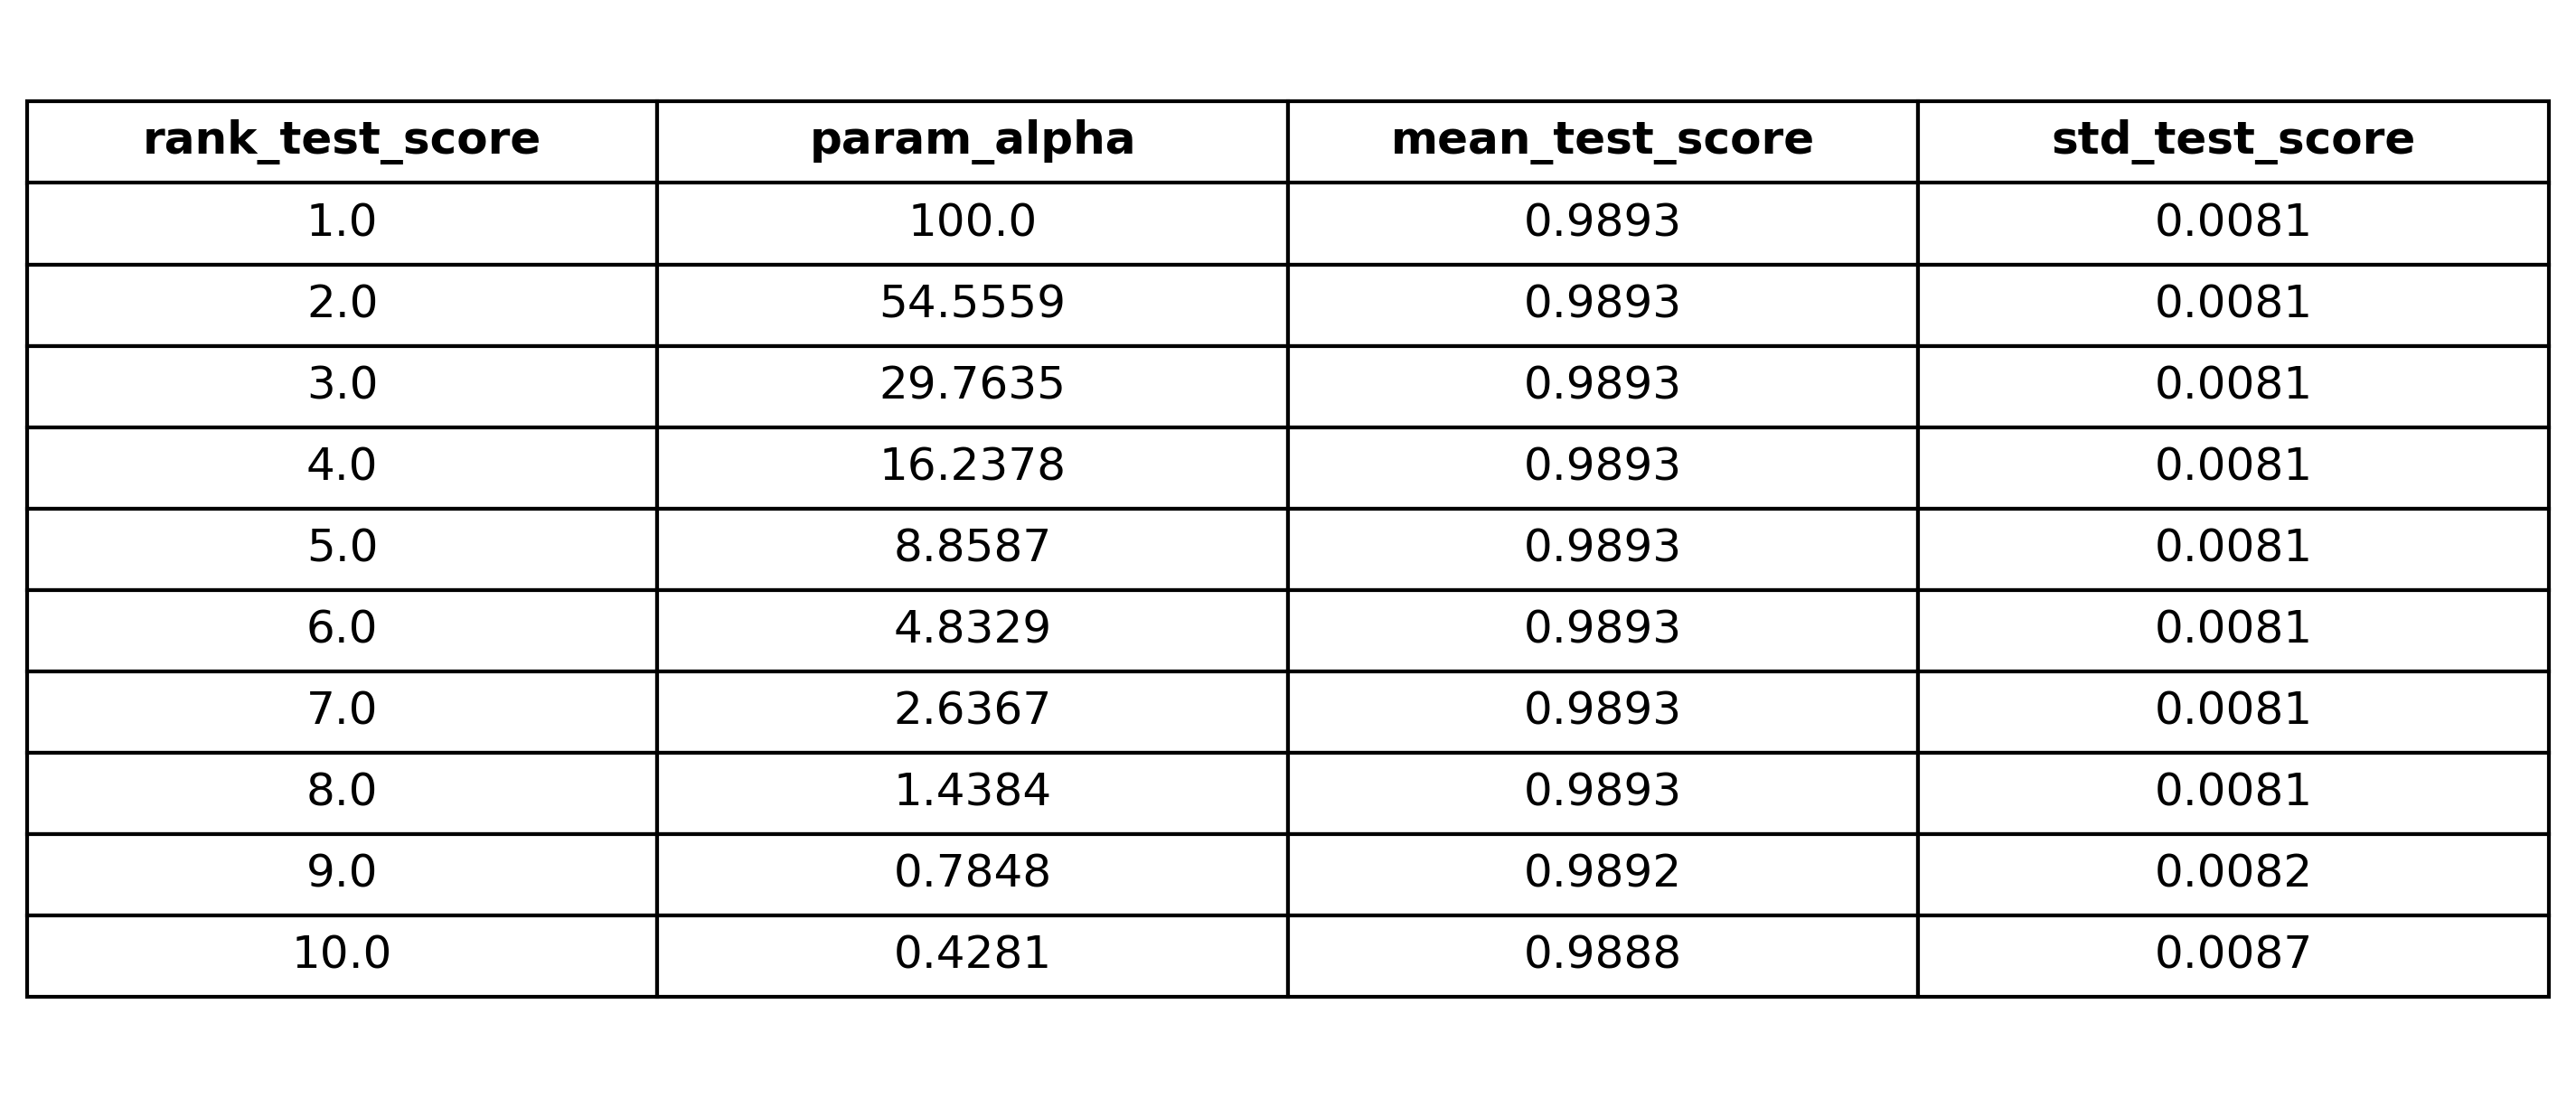

In [69]:
# Create a table image for model performance
# Round the numeric values to 6 decimal places
cv_results_rounded = cv_results.head(10).copy()
cv_results_rounded.iloc[:, 1:] = cv_results.head(10).iloc[:, 1:].round(4)  # Round all numeric columns

selected_col = ['rank_test_score', 'param_alpha', 'mean_test_score', 'std_test_score']
cv_res_round_sel = cv_results_rounded[selected_col]

plt.figure(figsize=(10, 5),dpi=300)
plt.axis('off')
table = plt.table(
    cellText=cv_res_round_sel.values,
    colLabels=cv_res_round_sel.columns,
    loc='center',
    cellLoc='center'
)

#Formatting table
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:  # Header row
        cell.set_text_props(fontweight='bold') 
        cell.set_text_props(horizontalalignment='center', verticalalignment='center')

table.scale(xscale=1, yscale=1.2)        
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
#plt.title('Model Performance Summary',weight='bold')
plt.savefig(r"C:\Users\bramb\OneDrive - Stanford\Desktop\nested_cv_results_table.png", bbox_inches='tight') # Save the figure (change file path) 
plt.show()
plt.close()

['cycle_number', 'avg_temperature', 'avg_current', 'current_kurtosis', 'current_variance', 'OCV_hysteresis']


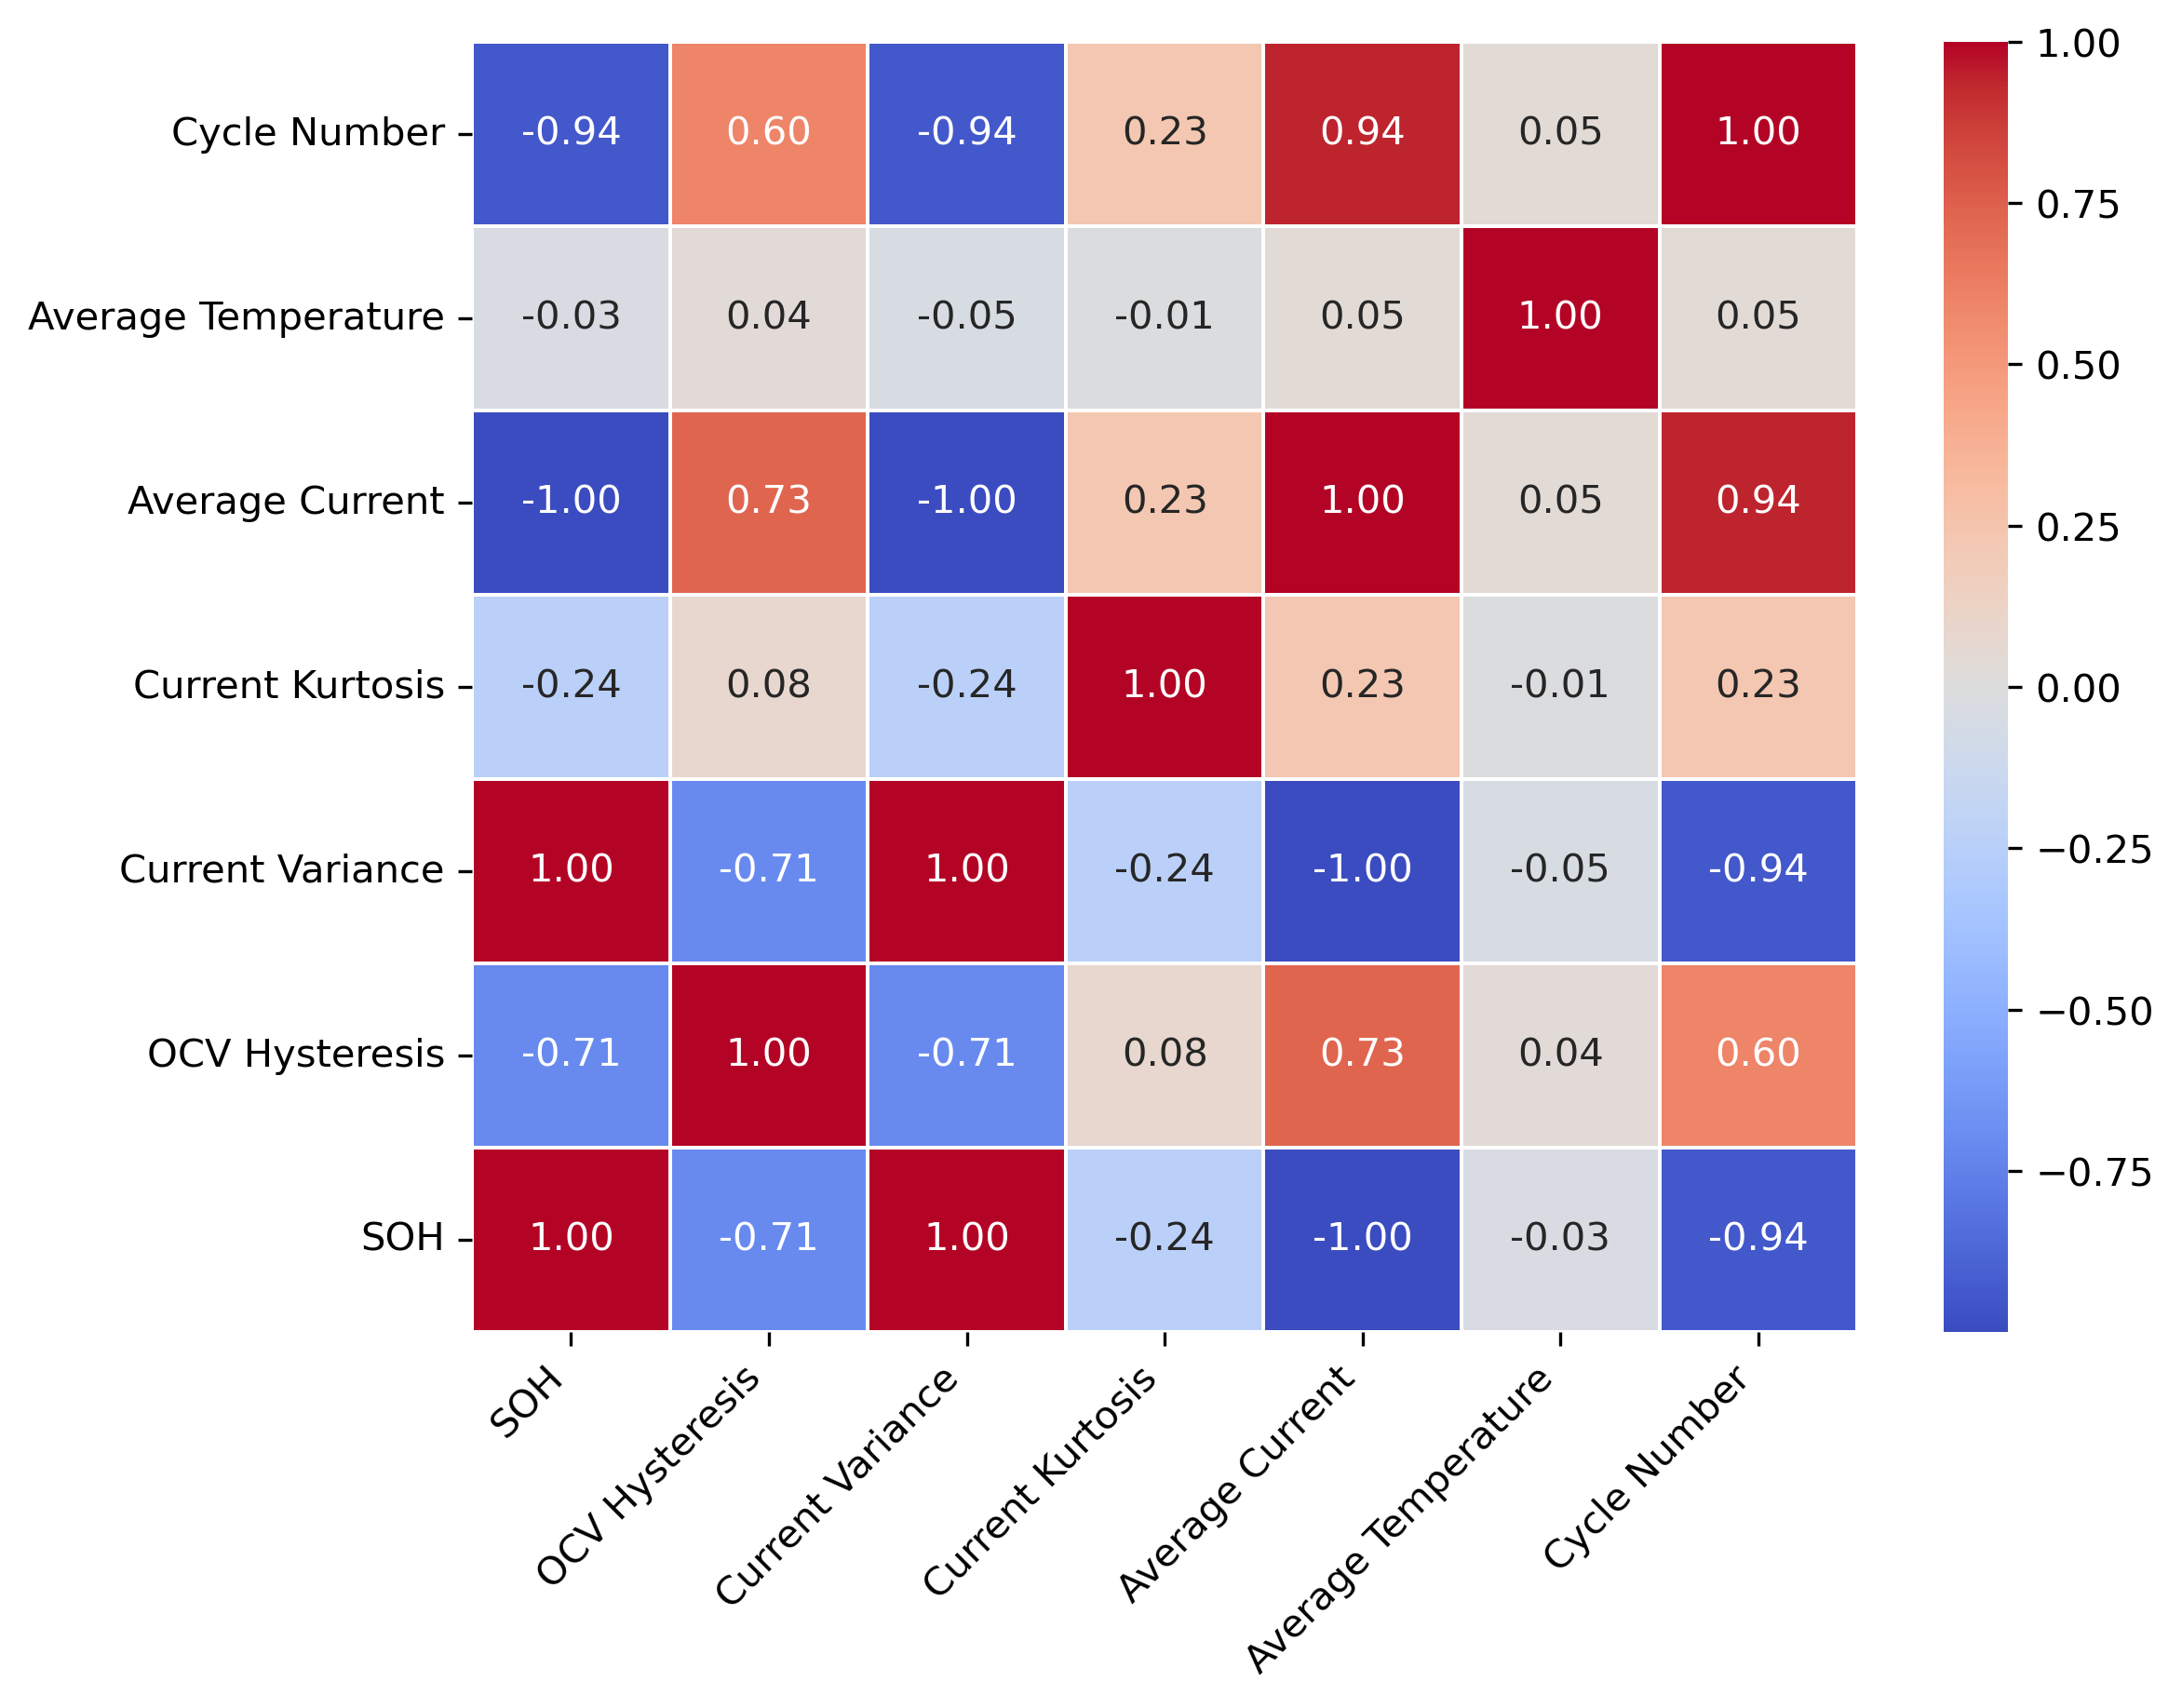

In [13]:
#Generate a correlation matrix to see if the features we have are good predictors for SOH 
print(features)
features1 = ['Cycle Number', 'Average Temperature', 'Average Current', 'Current Kurtosis', 'Current Variance', 'OCV Hysteresis']

df = pd.DataFrame(X_train, columns=features1) 
df["SOH"] = y_train
corr = df.corr()

#Reverse the x-axis (flip columns)
corr = corr.iloc[:, ::-1]  # Reverse column order

plt.figure(figsize=(8, 6),dpi=300)
sns.heatmap(
    corr, cmap="coolwarm", annot=True, fmt=".2f",
    linewidths=0.5, cbar=True
)

plt.xticks(rotation=45, ha="right")  
plt.savefig(r"C:\Users\bramb\OneDrive - Stanford\Desktop\corr_matrix.png", bbox_inches='tight') # Save the figure (change file path) 
plt.show()


In [ ]:
#Manually train and evaluate models with different alpha values
#Because k-fold nested CV may have over-regularized, use smaller alpha values and test if metrics are better.

print("\nEvaluating different alpha values for Ridge and Lasso regression...")

ridge_alphas = [0.1, 0.25, 0.5, 0.75, 1, 5, 10]
lasso_alphas = [0.1, 0.25, 0.5, 0.75, 1, 5, 10]

#Store Train & Test R² values for each Ridge & Lasso alpha
ridge_results = {
    alpha: {
        "R² Train": linear_model.Ridge(alpha=alpha).fit(X_train, y_train).score(X_train, y_train),
        "R² Test": linear_model.Ridge(alpha=alpha).fit(X_train, y_train).score(X_test, y_test)
    }
    for alpha in ridge_alphas
}

lasso_results = {
    alpha: {
        "R² Train": linear_model.Lasso(alpha=alpha, max_iter=10000).fit(X_train, y_train).score(X_train, y_train),
        "R² Test": linear_model.Lasso(alpha=alpha, max_iter=10000).fit(X_train, y_train).score(X_test, y_test)
    }
    for alpha in lasso_alphas
}

# Convert to dataframe
df_ridge_alphas = pd.DataFrame.from_dict(ridge_results, orient='index').reset_index()
df_ridge_alphas.columns = ["Ridge Alpha", "R² Train", "R² Test"]

df_lasso_alphas = pd.DataFrame.from_dict(lasso_results, orient='index').reset_index()
df_lasso_alphas.columns = ["Lasso Alpha", "R² Train", "R² Test"]

print("\nRidge Regression Alpha Tuning Results:")
print(df_ridge_alphas.to_string(index=False))  # Print as formatted table

print("\nLasso Regression Alpha Tuning Results:")
print(df_lasso_alphas.to_string(index=False))  # Print as formatted table

# Identify best alpha values
# Identify the best alpha based on the highest R² Test score
best_ridge_alpha = max(ridge_results, key=lambda alpha: ridge_results[alpha]["R² Test"])
best_lasso_alpha = max(lasso_results, key=lambda alpha: lasso_results[alpha]["R² Test"])

# Train final models with best alpha values
best_ridge = linear_model.Ridge(alpha=best_ridge_alpha)
best_ridge.fit(X_train, y_train)

best_lasso = linear_model.Lasso(alpha=best_lasso_alpha, max_iter=10000)
best_lasso.fit(X_train, y_train)

# Also train a standard linear regression model
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)

#Print metrics for each model
print("\nBest Fitting for Ridge:\n")
print("   Best alpha value:", best_ridge_alpha)
print("   Coefficients", best_ridge.coef_)
print("   Intercept:", best_ridge.intercept_)
y_train_pred = best_ridge.predict(X_train) #Predicted y-values for training set
y_test_pred = best_ridge.predict(X_test) #Predicted y-values for test set
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

print("\nBest Fitting for Lasso:\n")
print("   Best aplha value:", best_lasso_alpha)
print("   Coefficients", best_lasso.coef_)
print("   Intercept:", best_lasso.intercept_)
y_train_pred = best_lasso.predict(X_train) #Predicted y-values for training set
y_test_pred = best_lasso.predict(X_test) #Predicted y-values for test set
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

print("\nBest Fitting for OLS:\n")
print("   Coefficients", linear_reg.coef_)
print("   Intercept:", linear_reg.intercept_)
y_train_pred = linear_reg.predict(X_train) #Predicted y-values for training set
y_test_pred = linear_reg.predict(X_test) #Predicted y-values for test set
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))


Evaluating different alpha values for Ridge and Lasso regression...

Ridge Regression Alpha Tuning Results:
 Ridge Alpha  R² Train  R² Test
        0.10  0.996537 0.985444
        0.25  0.996533 0.985447
        0.50  0.996532 0.985448
        0.75  0.996531 0.985449
        1.00  0.996531 0.985449
        5.00  0.996530 0.985450
       10.00  0.996530 0.985451

Lasso Regression Alpha Tuning Results:
 Lasso Alpha  R² Train  R² Test
        0.10  0.996467 0.985499
        0.25  0.996361 0.985593
        0.50  0.996264 0.985569
        0.75  0.996216 0.985477
        1.00  0.996215 0.985475
        5.00  0.996215 0.985476
       10.00  0.996215 0.985477

Best Fitting for Ridge:

   Best aplha value: 10
   Coefficients [ 1.69515484e-02  8.08343602e-02 -7.01311042e-02  1.06818888e-05
  1.97050217e-03  1.47369668e-02]
   Intercept: -17.678221107496014
   R^2 Train: 0.9965303234095934
   R^2 Test: 0.9854511095056846
   RMSE: 0.6944124813313429
   MSE: 0.4822086942287526
   MAE: 0.5515670141

In [15]:
#Re-initialize training and test set variables 
X_train = train[features].values
X_test = test[features].values
y_train = train['SOH'].values
y_test = test['SOH'].values

#Arrays to collect metrics in 
intercept, coef, train_r2, test_r2, rmse, mse, mae = [], [], [], [], [], [], []
model = ["ridge_1", "ridge_2", "ridge_3", "lasso_1", "lasso_2", "lasso_3", "OLS"]
alpha = [1.438449888287663, 0.7847599703514607, 0.42813323987193913, 1.438449888287663, 0.7847599703514607, 0.42813323987193913,0]

0.9986167579007702
0.9755908887733564


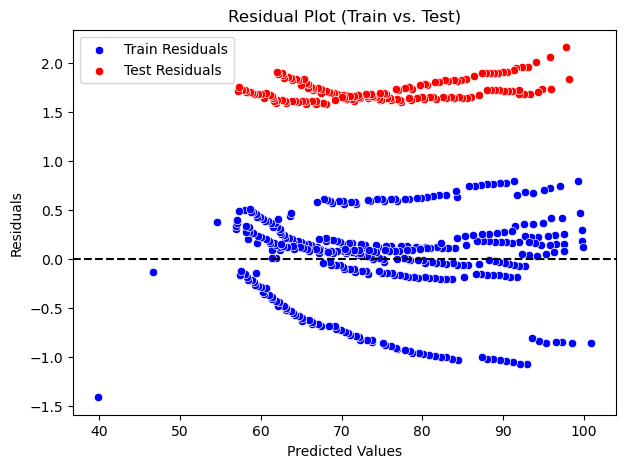

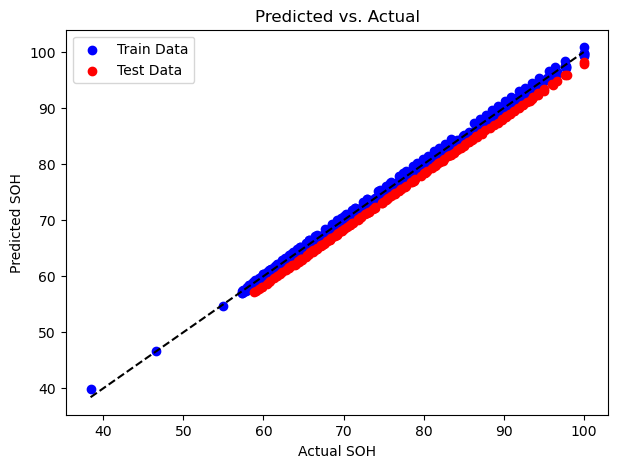


Fitting for Ridge_1:

   Aplha value: 1.438449888287663
   Coefficients [-2.71443586e-02  4.15376351e-02  2.34468104e-02  1.00259869e-05
  2.23943860e-03 -6.01790678e-02]
   Intercept: 5.800024875343155
   R^2 Train: 0.9986167579007702
   R^2 Test: 0.9755908887733564
   RMSE: 0.4486576896990774
   MSE: 0.2012937225261136
   MAE: 0.33768536966574725


In [16]:
#Look at more reasonable values (<2) for regularization, based on k-fold nested cross validation 
#Ridge_1 is a ridge regression model based on the 8th highest 'rank_test_score' from k-fold nested CV (alpha = 1.438449888287663)
ridge_1 = linear_model.Ridge(alpha=1.438449888287663)
ridge_1.fit(X_train, y_train)
y_train_pred = ridge_1.predict(X_train) #Predicted y-values for training set
y_test_pred = ridge_1.predict(X_test) #Predicted y-values for test set

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

train_residuals = y_train - ridge_1.predict(X_train)
test_residuals = y_test - ridge_1.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_train_pred, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_test_pred, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Train vs. Test)")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_train, y_train_pred, color="blue", label="Train Data")
plt.scatter(y_test, y_test_pred, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs. Actual")
plt.legend()
plt.show()

coef.append(ridge_1.coef_)
intercept.append(ridge_1.intercept_)
train_r2.append(r2_score(y_train, y_train_pred))
test_r2.append(r2_score(y_test, y_test_pred))
rmse.append(root_mean_squared_error(y_train, y_train_pred))
mse.append(mean_squared_error(y_train, y_train_pred))
mae.append(mean_absolute_error(y_train, y_train_pred))

print("\nFitting for Ridge_1:\n")
print("   Aplha value: 1.438449888287663")
print("   Coefficients", ridge_1.coef_)
print("   Intercept:", ridge_1.intercept_)
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

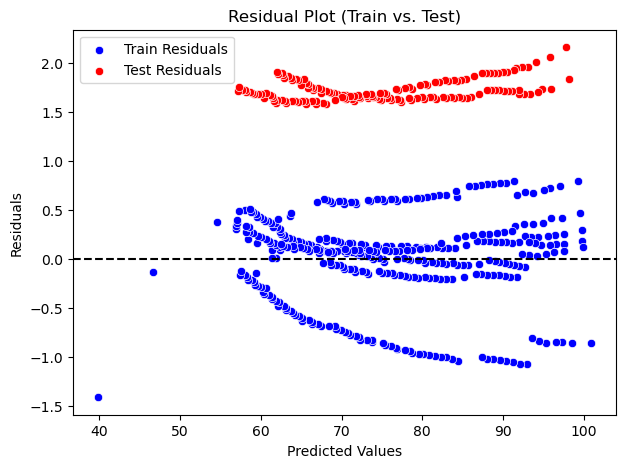

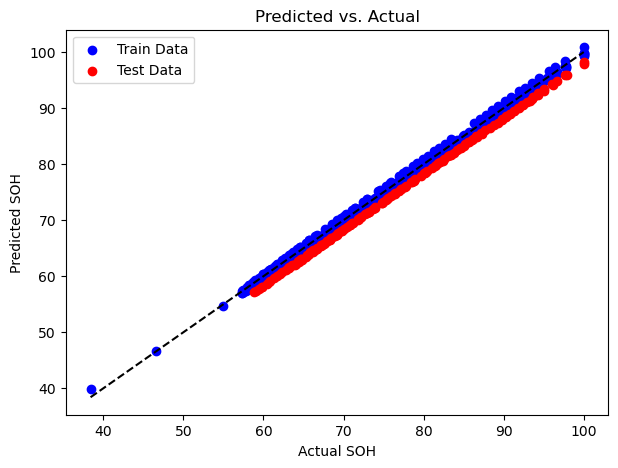


Fitting for Ridge_2:

   Aplha value: 0.7847599703514607
   Coefficients [-2.71634077e-02  4.15510979e-02  2.36150840e-02  1.84784358e-05
  2.24012342e-03 -1.10257716e-01]
   Intercept: 5.831860308571862
   R^2 Train: 0.9986169208576932
   R^2 Test: 0.9755877642781505
   R^2 Train: 0.9986169208576932
   R^2 Test: 0.9755877642781505
   RMSE: 0.4486312611982137
   MSE: 0.20127000852429988
   MAE: 0.33765490066907694


In [17]:
#Ridge_2 is a ridge regression model based on the 9th highest 'rank_test_score' from k-fold nested CV (alpha = 0.7847599703514607)
ridge_2 = linear_model.Ridge(alpha=0.7847599703514607)
ridge_2.fit(X_train, y_train)
y_train_pred = ridge_2.predict(X_train) #Predicted y-values for training set
y_test_pred = ridge_2.predict(X_test) #Predicted y-values for test set

train_residuals = y_train - ridge_2.predict(X_train)
test_residuals = y_test - ridge_2.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_train_pred, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_test_pred, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Train vs. Test)")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_train, y_train_pred, color="blue", label="Train Data")
plt.scatter(y_test, y_test_pred, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs. Actual")
plt.legend()
plt.show()

coef.append(ridge_2.coef_)
intercept.append(ridge_2.intercept_)
train_r2.append(r2_score(y_train, y_train_pred))
test_r2.append(r2_score(y_test, y_test_pred))
rmse.append(root_mean_squared_error(y_train, y_train_pred))
mse.append(mean_squared_error(y_train, y_train_pred))
mae.append(mean_absolute_error(y_train, y_train_pred))

print("\nFitting for Ridge_2:\n")
print("   Aplha value: 0.7847599703514607")
print("   Coefficients", ridge_2.coef_)
print("   Intercept:", ridge_2.intercept_)
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

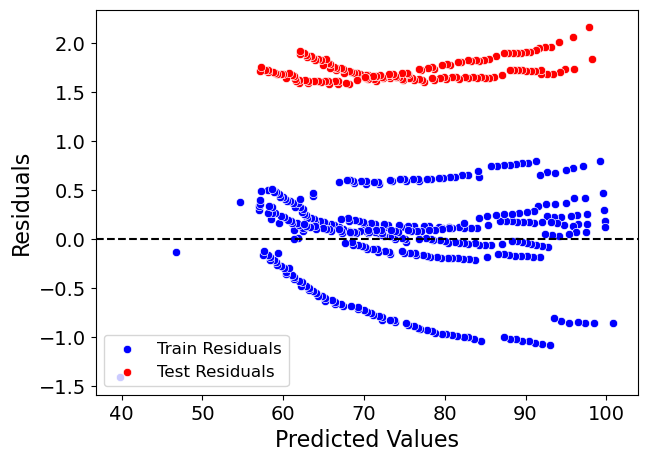

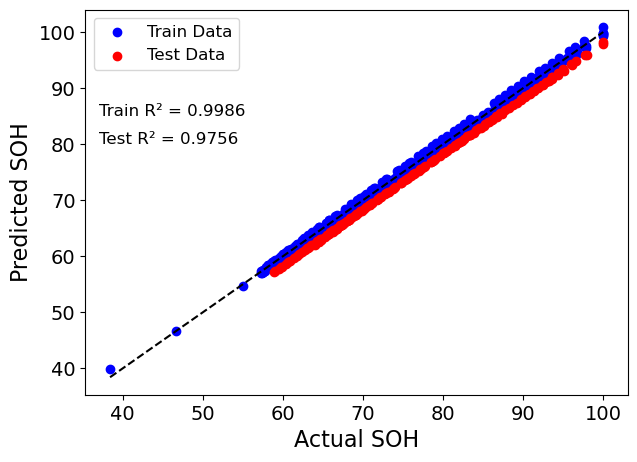


Fitting for Ridge_3:

   Aplha value: 1.438449888287663
   Coefficients [-2.71953715e-02  4.15557116e-02  2.38804141e-02  3.40316749e-05
  2.24118703e-03 -2.01797645e-01]
   Intercept: 5.883722505584032
   R^2 Train: 0.9986172182246086
   R^2 Test: 0.9755825208498696
   R^2 Train: 0.9986172182246086
   R^2 Test: 0.9755825208498696
   RMSE: 0.4485830299503435
   MSE: 0.2012267347594308
   MAE: 0.3376020852677597


In [18]:
#Ridge_3 is a ridge regression model based on the 10th highest 'rank_test_score' from k-fold nested CV (alpha = 0.42813323987193913)
ridge_3 = linear_model.Ridge(alpha=0.42813323987193913)
ridge_3.fit(X_train, y_train)
y_train_pred = ridge_3.predict(X_train) #Predicted y-values for training set
y_test_pred = ridge_3.predict(X_test) #Predicted y-values for test set

train_residuals = y_train - ridge_3.predict(X_train)
test_residuals = y_test - ridge_3.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_train_pred, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_test_pred, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values",fontsize=16)
plt.ylabel("Residuals",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Residual Plot (Train vs. Test)")
plt.legend(fontsize=12)
plt.savefig(r"C:\Users\bramb\OneDrive - Stanford\Desktop\ridge_3_residuals.png", bbox_inches='tight') # Save the figure (change file path) 
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_train, y_train_pred, color="blue", label="Train Data")
plt.scatter(y_test, y_test_pred, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH",fontsize=16)
plt.ylabel("Predicted SOH",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(37, 80,f"Test R² = {r2_score(y_test, y_test_pred):.4f}", fontsize=12)
plt.text(37, 85,f"Train R² = {r2_score(y_train, y_train_pred):.4f}", fontsize=12)
#plt.title("Predicted vs. Actual")
plt.legend(fontsize=12)
plt.savefig(r"C:\Users\bramb\OneDrive - Stanford\Desktop\ridge_3_fit.png", bbox_inches='tight') # Save the figure (change file path) 
plt.show()

coef.append(ridge_3.coef_)
intercept.append(ridge_3.intercept_)
train_r2.append(r2_score(y_train, y_train_pred))
test_r2.append(r2_score(y_test, y_test_pred))
rmse.append(root_mean_squared_error(y_train, y_train_pred))
mse.append(mean_squared_error(y_train, y_train_pred))
mae.append(mean_absolute_error(y_train, y_train_pred))

print("\nFitting for Ridge_3:\n")
print("   Aplha value: 1.438449888287663")
print("   Coefficients", ridge_3.coef_)
print("   Intercept:", ridge_3.intercept_)
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

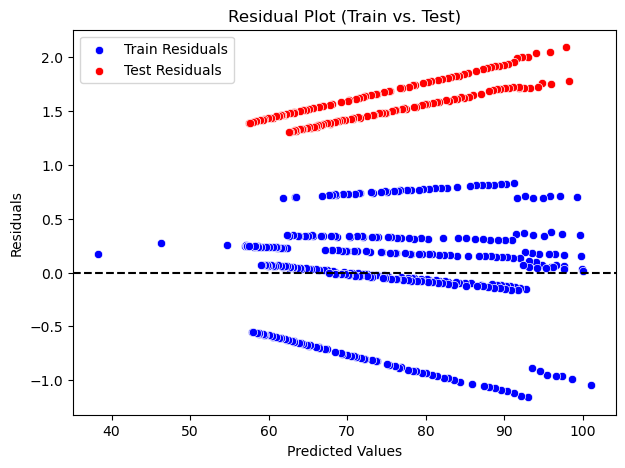

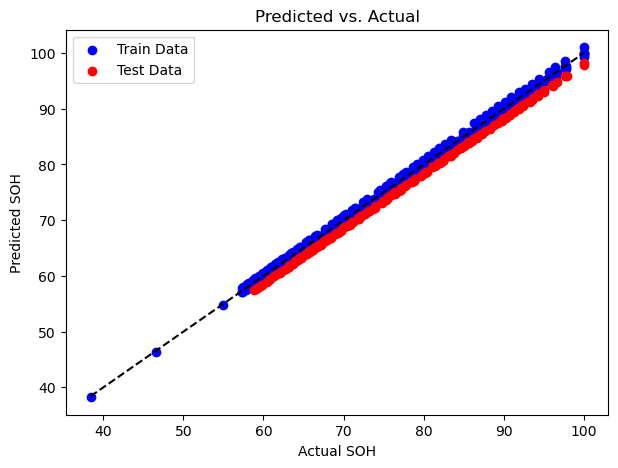


Fitting for lasso_1:

   Aplha value: 1.438449888287663
   Coefficients [-0.          0.         -0.         -0.          0.00222621  0.        ]
   Intercept: -0.4259270245227782
   R^2 Train: 0.9983660179647774
   R^2 Test: 0.9791006308178016
   RMSE: 0.48762914527016654
   MSE: 0.2377821833169132
   MAE: 0.3683423655880419


In [19]:
#Lasso_1 is a lasso regression model based on the 8th highest 'rank_test_score' from k-fold nested CV (alpha = 1.438449888287663)
lasso_1 = linear_model.Lasso(alpha=1.438449888287663)
lasso_1.fit(X_train, y_train)
y_train_pred = lasso_1.predict(X_train) #Predicted y-values for training set
y_test_pred = lasso_1.predict(X_test) #Predicted y-values for test set

train_residuals = y_train - lasso_1.predict(X_train)
test_residuals = y_test - lasso_1.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_train_pred, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_test_pred, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Train vs. Test)")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_train, y_train_pred, color="blue", label="Train Data")
plt.scatter(y_test, y_test_pred, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs. Actual")
plt.legend()
plt.show()

coef.append(lasso_1.coef_)
intercept.append(lasso_1.intercept_)
train_r2.append(r2_score(y_train, y_train_pred))
test_r2.append(r2_score(y_test, y_test_pred))
rmse.append(root_mean_squared_error(y_train, y_train_pred))
mse.append(mean_squared_error(y_train, y_train_pred))
mae.append(mean_absolute_error(y_train, y_train_pred))

print("\nFitting for lasso_1:\n")
print("   Aplha value: 1.438449888287663")
print("   Coefficients", lasso_1.coef_)
print("   Intercept:", lasso_1.intercept_)
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

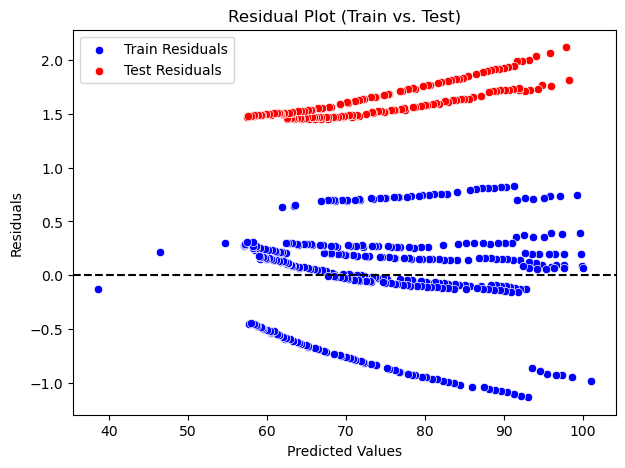

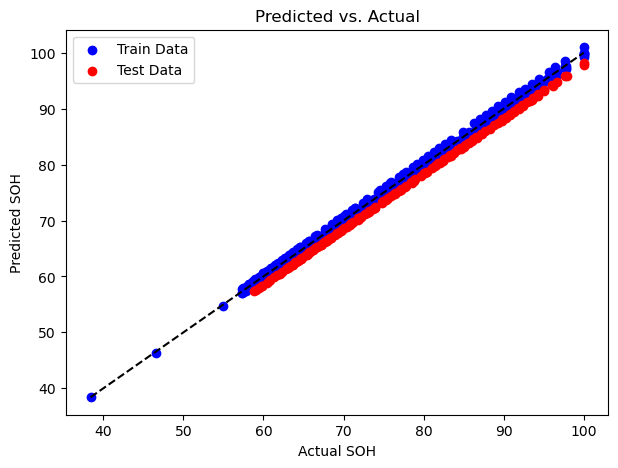


Fitting for lasso_2:

   Aplha value: 0.7847599703514607
   Coefficients [-0.00641652  0.         -0.         -0.          0.00220319  0.        ]
   Intercept: 0.5703422641942097
   R^2 Train: 0.9984457277480312
   R^2 Test: 0.9782893930298756
   RMSE: 0.4755865494425878
   MSE: 0.22618256601070702
   MAE: 0.3611409435221672


In [20]:
#Lasso_2 is a lasso regression model based on the 9th highest 'rank_test_score' from k-fold nested CV (alpha = 0.7847599703514607)
lasso_2 = linear_model.Lasso(alpha=0.7847599703514607)
lasso_2.fit(X_train, y_train)
y_train_pred = lasso_2.predict(X_train) #Predicted y-values for training set
y_test_pred = lasso_2.predict(X_test) #Predicted y-values for test set

train_residuals = y_train - lasso_2.predict(X_train)
test_residuals = y_test - lasso_2.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_train_pred, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_test_pred, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Train vs. Test)")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_train, y_train_pred, color="blue", label="Train Data")
plt.scatter(y_test, y_test_pred, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs. Actual")
plt.legend()
plt.show()

coef.append(lasso_2.coef_)
intercept.append(lasso_2.intercept_)
train_r2.append(r2_score(y_train, y_train_pred))
test_r2.append(r2_score(y_test, y_test_pred))
rmse.append(root_mean_squared_error(y_train, y_train_pred))
mse.append(mean_squared_error(y_train, y_train_pred))
mae.append(mean_absolute_error(y_train, y_train_pred))

print("\nFitting for lasso_2:\n")
print("   Aplha value: 0.7847599703514607")
print("   Coefficients", lasso_2.coef_)
print("   Intercept:", lasso_2.intercept_)
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

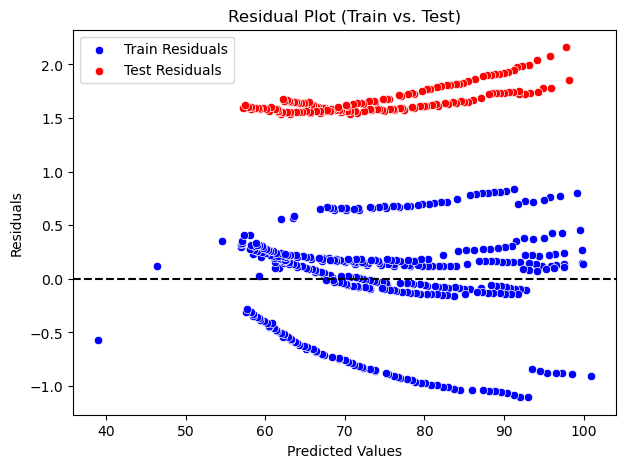

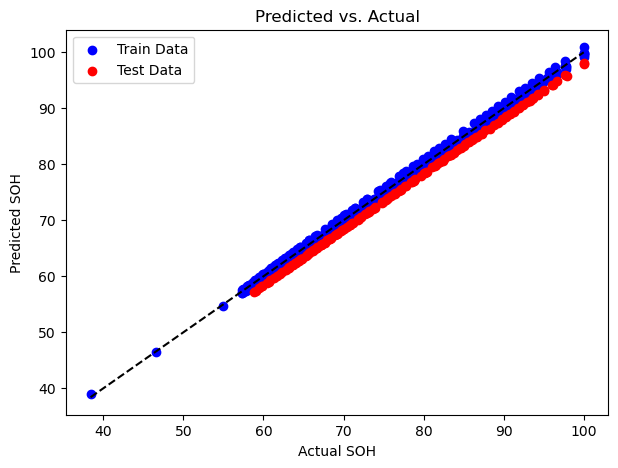


Fitting for lasso_3:

   Aplha value: 0.42813323987193913
   Coefficients [-0.01577527  0.          0.         -0.          0.00216959 -0.        ]
   Intercept: 2.0241357187457254
   R^2 Train: 0.9985235021540425
   R^2 Test: 0.977025058555009
   RMSE: 0.4635348863487367
   MSE: 0.21486459086233622
   MAE: 0.3521750118121057


In [21]:
#Lasso_3 is a lasso regression model based on the 10th highest 'rank_test_score' from k-fold nested CV (alpha = 0.42813323987193913)
lasso_3 = linear_model.Lasso(alpha=0.42813323987193913)
lasso_3.fit(X_train, y_train)
y_train_pred = lasso_3.predict(X_train) #Predicted y-values for training set
y_test_pred = lasso_3.predict(X_test) #Predicted y-values for test set

train_residuals = y_train - lasso_3.predict(X_train)
test_residuals = y_test - lasso_3.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_train_pred, y=train_residuals, color="blue", label="Train Residuals")
sns.scatterplot(x=y_test_pred, y=test_residuals, color="red", label="Test Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Train vs. Test)")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_train, y_train_pred, color="blue", label="Train Data")
plt.scatter(y_test, y_test_pred, color="red", label="Test Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--")  # 1:1 line
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs. Actual")
plt.legend()
plt.show()

coef.append(lasso_3.coef_)
intercept.append(lasso_3.intercept_)
train_r2.append(r2_score(y_train, y_train_pred))
test_r2.append(r2_score(y_test, y_test_pred))
rmse.append(root_mean_squared_error(y_train, y_train_pred))
mse.append(mean_squared_error(y_train, y_train_pred))
mae.append(mean_absolute_error(y_train, y_train_pred))

print("\nFitting for lasso_3:\n")
print("   Aplha value: 0.42813323987193913")
print("   Coefficients", lasso_3.coef_)
print("   Intercept:", lasso_3.intercept_)
print("   R^2 Train:", r2_score(y_train, y_train_pred))
print("   R^2 Test:", r2_score(y_test, y_test_pred))
print("   RMSE:", root_mean_squared_error(y_train, y_train_pred))
print("   MSE:", mean_squared_error(y_train, y_train_pred))
print("   MAE:", mean_absolute_error(y_train, y_train_pred))

In [22]:
#Re-initialize training and test set variables 
X_train = train[features].values
X_test = test[features].values
y_train = train['SOH'].values
y_test = test['SOH'].values

#Fit another OLS for comparison 
OLS = linear_model.LinearRegression()
OLS.fit(X_train, y_train)
y_pred = OLS.predict(X_test)

y_train_pred = OLS.predict(X_train) #Predicted y-values for training set
y_test_pred = OLS.predict(X_test) #Predicted y-values for test set

coef.append(OLS.coef_)
intercept.append(OLS.intercept_)
train_r2.append(r2_score(y_train, y_train_pred))
test_r2.append(r2_score(y_test, y_test_pred))
rmse.append(root_mean_squared_error(y_train, y_train_pred))
mse.append(mean_squared_error(y_train, y_train_pred))
mae.append(mean_absolute_error(y_train, y_train_pred))

In [23]:
#Create a dictionary of metric names and values
metrics_dict = {
    "Model": model,
    "Alpha": alpha,
    "Train R²": train_r2,
    "Test R²": test_r2,
    "RMSE": rmse,
    "MSE": mse,
    "MAE": mae
}

#print(metrics_dict)
#Convert metrics dict to dataframe
df_metrics = pd.DataFrame(metrics_dict)
print(df_metrics)
print("\n")

#Convert into a dataframe with models as rows and features as columns
coef_np = np.array(coef)
df_coef = pd.DataFrame(coef_np, columns=features)
df_coef.insert(0, 'Model', model)
print(df_coef)
    

     Model     Alpha  Train R²   Test R²      RMSE       MSE       MAE
0  ridge_1  1.438450  0.998617  0.975591  0.448658  0.201294  0.337685
1  ridge_2  0.784760  0.998617  0.975588  0.448631  0.201270  0.337655
2  ridge_3  0.428133  0.998617  0.975583  0.448583  0.201227  0.337602
3  lasso_1  1.438450  0.998366  0.979101  0.487629  0.237782  0.368342
4  lasso_2  0.784760  0.998446  0.978289  0.475587  0.226183  0.361141
5  lasso_3  0.428133  0.998524  0.977025  0.463535  0.214865  0.352175
6      OLS  0.000000  0.998700  0.972560  0.434877  0.189118  0.330420


     Model  cycle_number  avg_temperature  avg_current  current_kurtosis  \
0  ridge_1     -0.027144         0.041538     0.023447          0.000010   
1  ridge_2     -0.027163         0.041551     0.023615          0.000018   
2  ridge_3     -0.027195         0.041556     0.023880          0.000034   
3  lasso_1     -0.000000         0.000000    -0.000000         -0.000000   
4  lasso_2     -0.006417         0.000000    -0.00

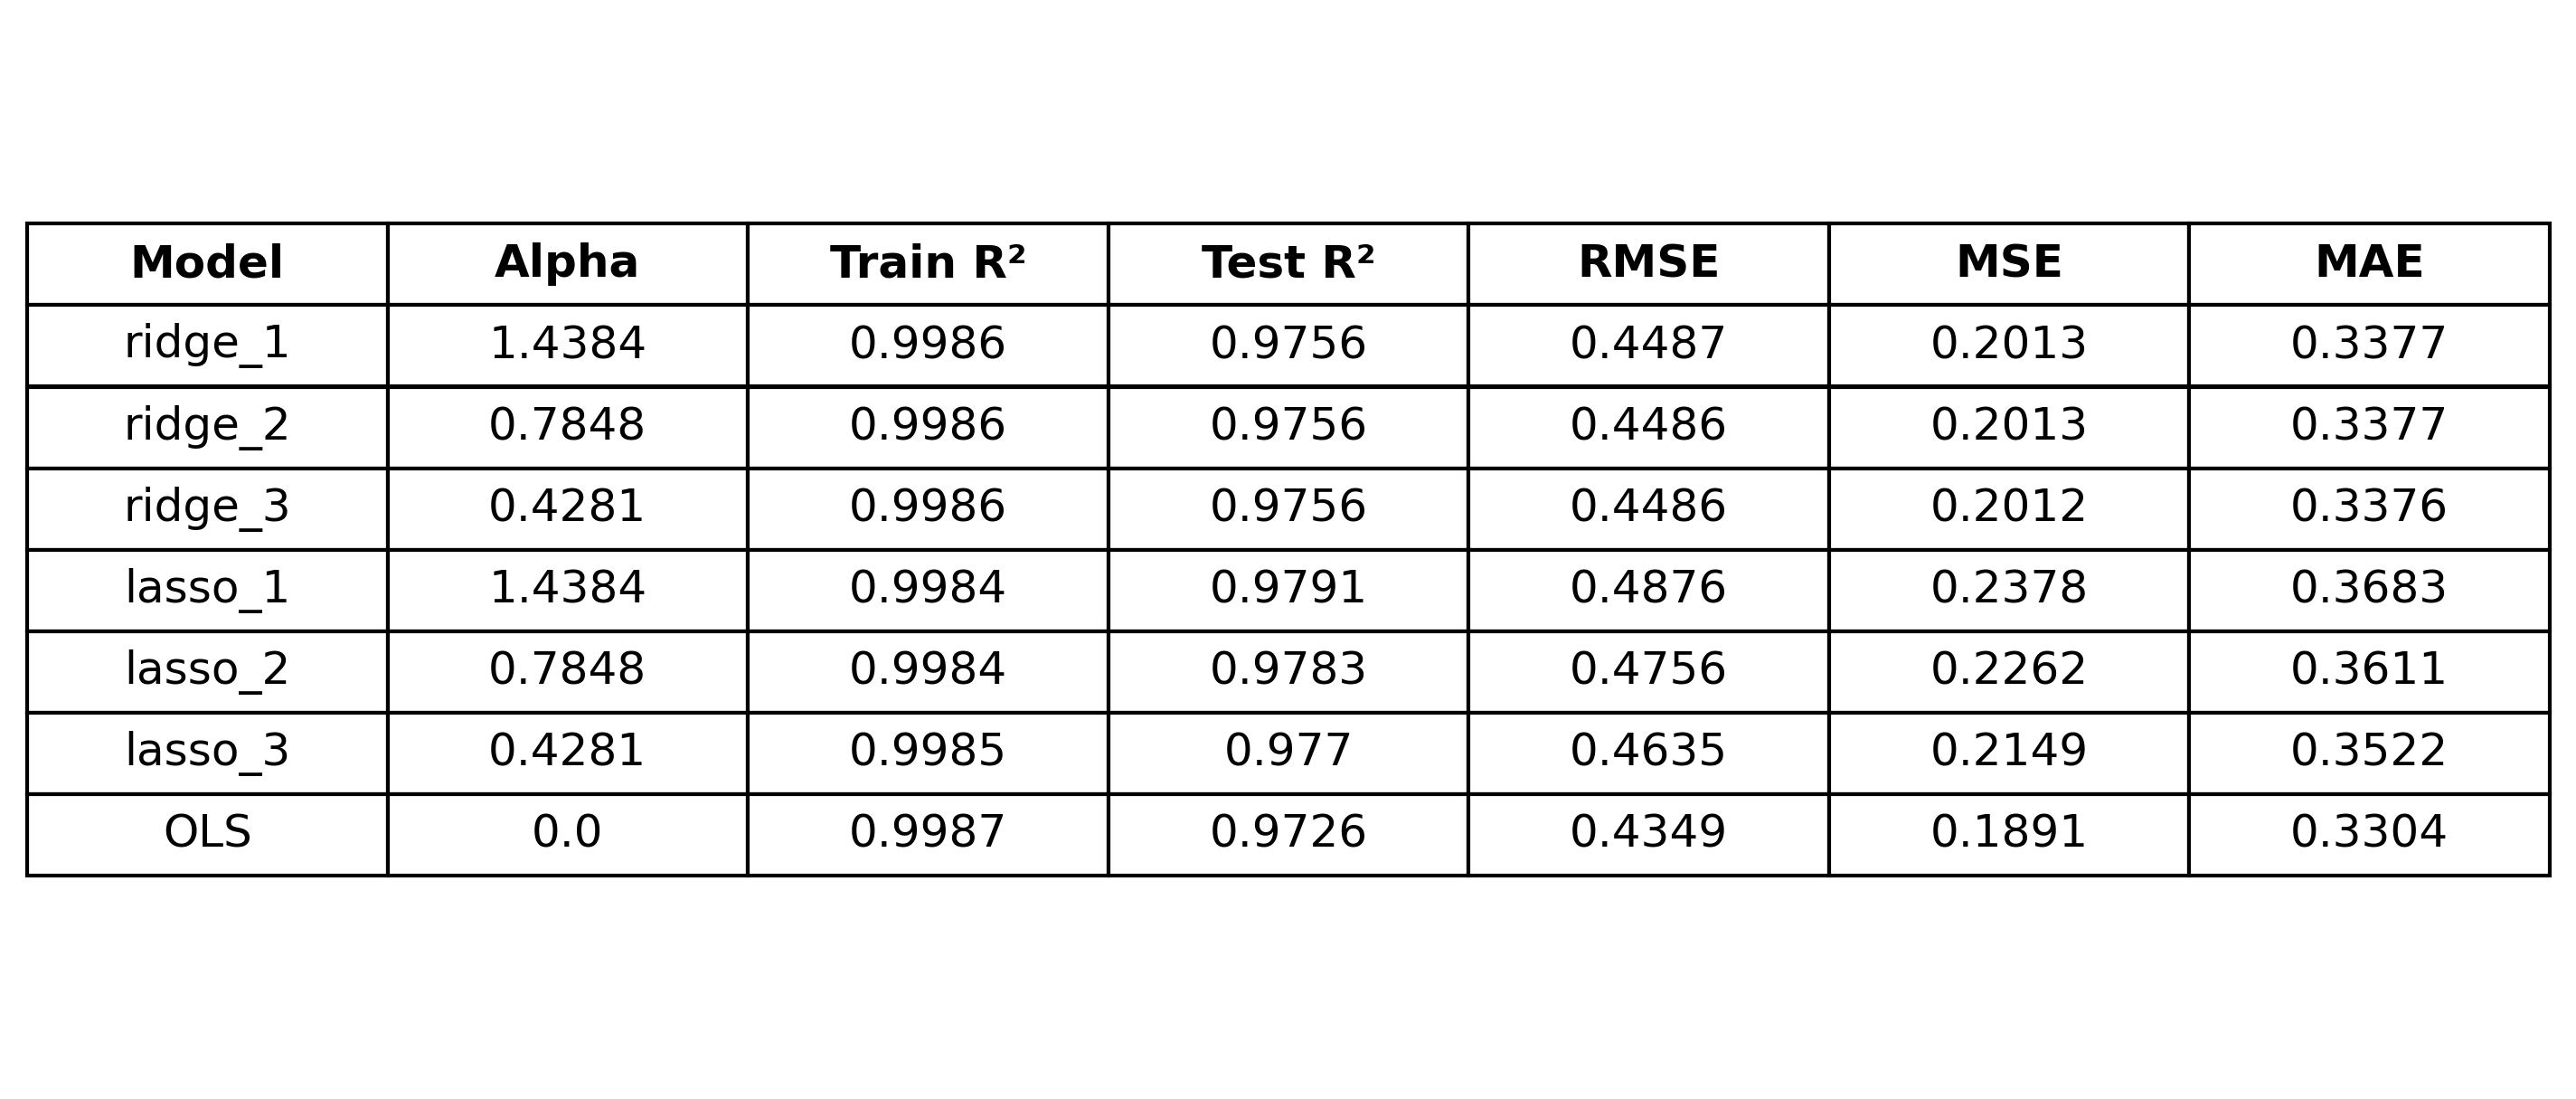

In [24]:
# Create a table image for model performance
# Round the numeric values to 3 decimal places (adjust as needed)
df_metrics_rounded = df_metrics.copy()
df_metrics_rounded.iloc[:, 1:] = df_metrics.iloc[:, 1:].round(4)  # Round all numeric columns

plt.figure(figsize=(10, 5),dpi=300)
plt.axis('off')
table = plt.table(
    cellText=df_metrics_rounded.values,
    colLabels=df_metrics_rounded.columns,
    loc='center',
    cellLoc='center'
)

#Formatting table
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:  # Header row
        cell.set_text_props(fontweight='bold') 
        cell.set_text_props(horizontalalignment='center', verticalalignment='center')

table.scale(xscale=1, yscale=1.2)        
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
#plt.title('Model Performance Summary',weight='bold')
plt.savefig(r"C:\Users\bramb\OneDrive - Stanford\Desktop\model_performance_table1.png", bbox_inches='tight') # Save the figure (change file path) 
plt.show()
plt.close()

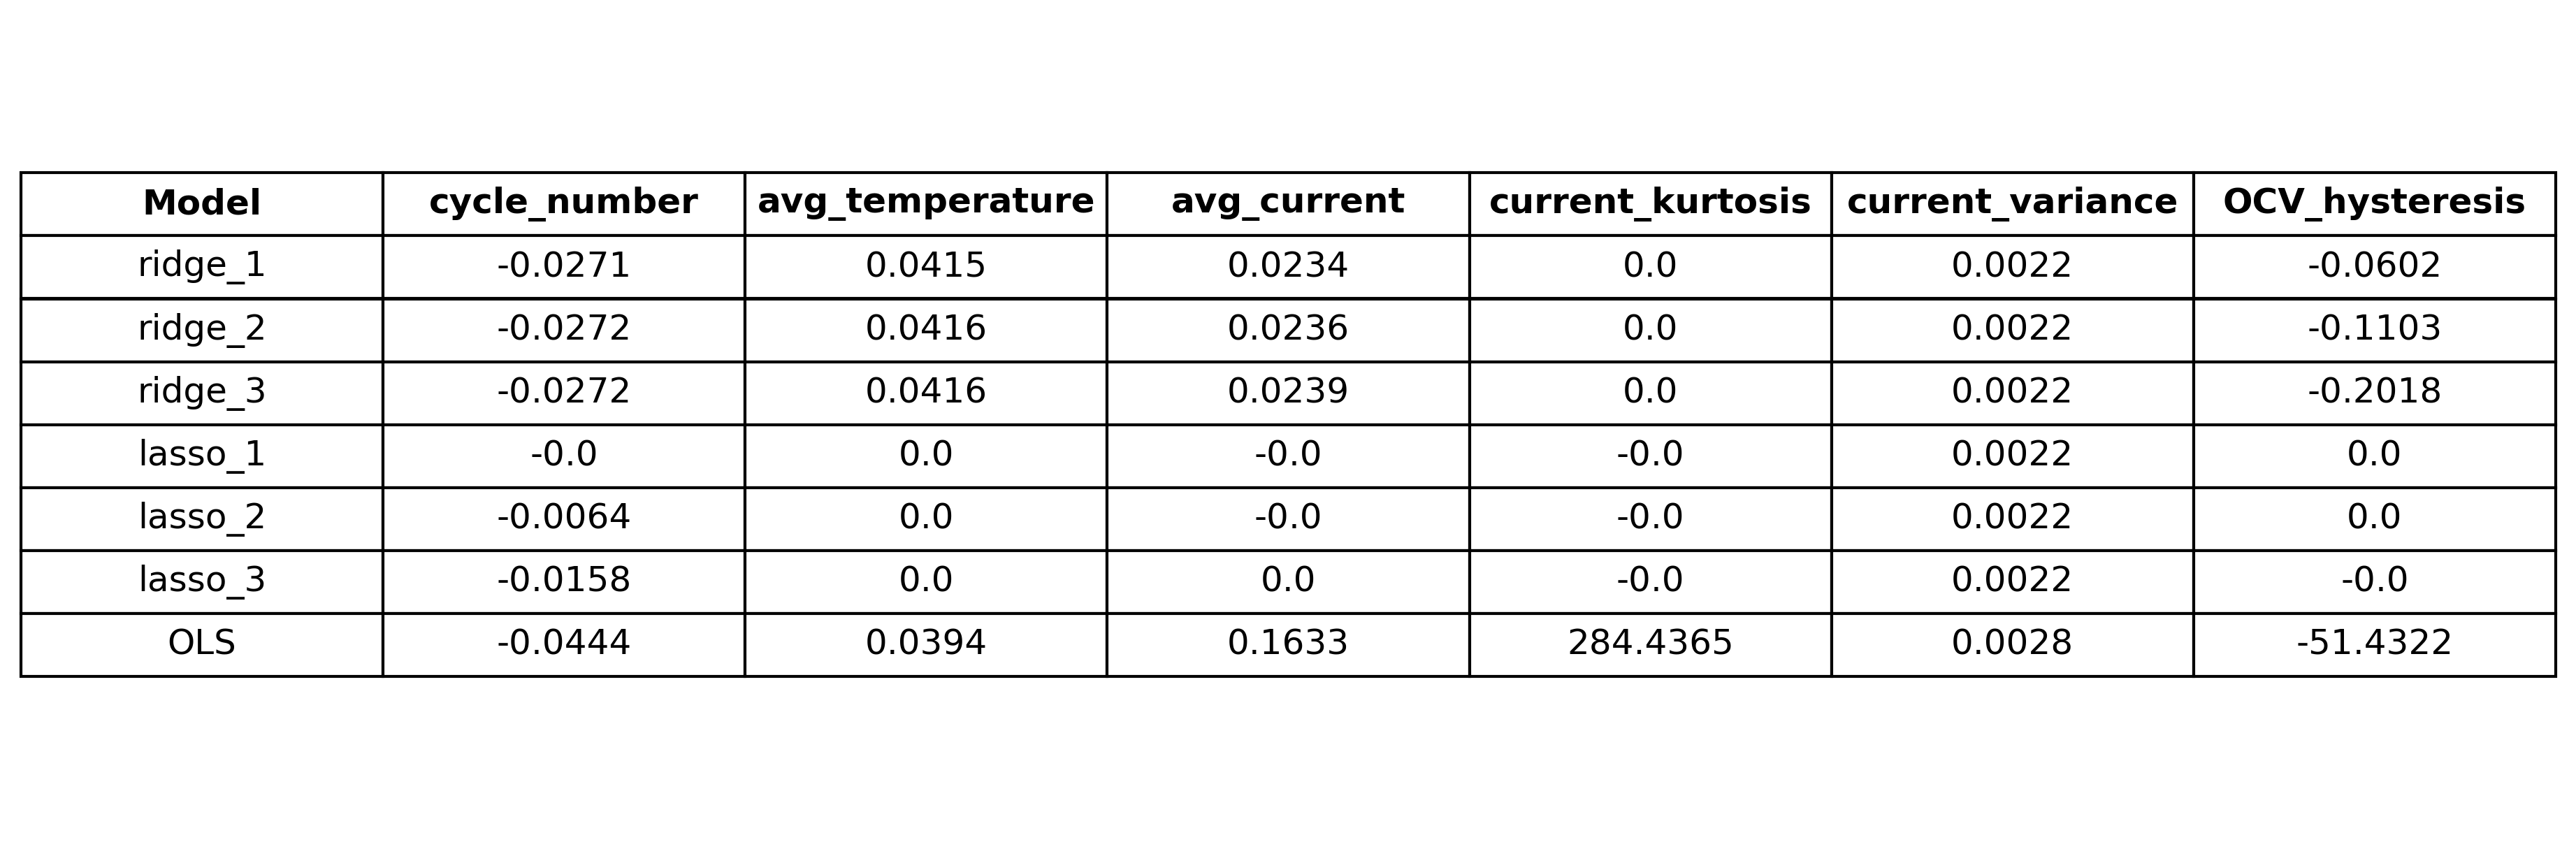

In [25]:
#Coefficients table
df_coef_r = df_coef.copy()
df_coef_r.iloc[:, 1:] = df_coef_r.iloc[:, 1:].round(4)  # Round all numeric columns

plt.figure(figsize=(13, 5),dpi=300)
plt.axis('off')
table = plt.table(
    cellText=df_coef_r.values,
    colLabels=df_coef_r.columns,
    loc='center',
    cellLoc='center'
)

#Formatting table
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:  # Header row
        cell.set_text_props(fontweight='bold') 
        cell.set_text_props(horizontalalignment='center', verticalalignment='center') 

table.scale(xscale=1, yscale=1.2)              
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
#plt.title('Model Coefficients',weight='bold')
plt.savefig(r"C:\Users\bramb\OneDrive - Stanford\Desktop\model_coef_table1.png", bbox_inches='tight') # Save the figure (change file path) 
plt.show()
plt.close()